In [1]:
!pip install flower torch torchaudio pandas librosa soundfile transformers evaluate flwr ray[default] jiwer sacrebleu
!pip install -U "flwr[simulation]"

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import numpy as np
import torchaudio
import pandas as pd
import librosa
import traceback
import soundfile as sf
from pathlib import Path
from collections import OrderedDict
from typing import List, Union
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import evaluate
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*path is deprecated.*")

Scalar = Union[bool, bytes, float, int, str]

# Define paths using Drive mount
DRIVE_PATH = "/content/drive/MyDrive/Federated Testing ML"
TRAIN_PATH = Path(os.path.join(DRIVE_PATH, "train_subset/train_subset.tsv"))
TEST_PATH  = Path(os.path.join(DRIVE_PATH, "test_subset/test_subset.tsv"))

print("\nChecking specific paths:")
print(f"Train TSV exists: {os.path.exists(TRAIN_PATH)}")
print(f"Test TSV exists: {os.path.exists(TEST_PATH)}")
print("\nFull paths being used:")
print(f"Train TSV: {TRAIN_PATH}")
print(f"Test TSV: {TEST_PATH}")

if os.path.exists(TRAIN_PATH):
    print("\nFirst few lines of train_subset.tsv:")
    !head -n 3 "{TRAIN_PATH}"

if os.path.exists(TEST_PATH):
    print("\nFirst few lines of test_subset.tsv:")
    !head -n 3 "{TEST_PATH}"

#########################################
# Dataset and Client Definitions
#########################################

class WhisperDataset(Dataset):
    def __init__(self, tsv_path, client_id=None, num_clients=None, max_samples=-1):
        print(f"Attempting to load TSV from: {tsv_path}")
        try:
            self.df = pd.read_csv(tsv_path, sep='\t')
            if client_id is not None and num_clients is not None:
                unique_clients = self.df['client_id'].unique()
                num_original_clients = len(unique_clients)
                clients_per_fed_client = num_original_clients // num_clients
                start_idx = client_id * clients_per_fed_client
                end_idx = (client_id + 1) * clients_per_fed_client
                assigned_clients = unique_clients[start_idx:end_idx]
                self.df = self.df[self.df['client_id'].isin(assigned_clients)]
                print(f"Federated Client {client_id} assigned {len(assigned_clients)} original clients")
                print(f"Number of samples for client {client_id}: {len(self.df)}")
            if max_samples > 0:
                self.df = self.df.head(max_samples)
            self.base_dir = Path(tsv_path).parent
            print(f"Dataset loaded with {len(self.df)} samples")
        except Exception as e:
            print(f"Error loading dataset: {str(e)}")
            raise

    def __len__(self):
        return len(self.df)

    def _load_audio(self, audio_path):
        try:
            waveform, _ = librosa.load(audio_path, sr=16000, mono=True)
            target_length = 16000 * 30  # 30 seconds target
            if len(waveform) < target_length:
                waveform = np.pad(waveform, (0, target_length - len(waveform)))
            else:
                waveform = waveform[:target_length]
            return waveform
        except Exception as e:
            print(f"Error loading audio file {audio_path}: {str(e)}")
            return np.zeros(16000 * 30)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = self.base_dir / row['path']
        try:
            audio = self._load_audio(audio_path)
            return {
                "audio": audio,
                "text": row['sentence'],
                "path": str(audio_path)
            }
        except Exception as e:
            print(f"Error getting item {idx}: {str(e)}")
            return {
                "audio": np.zeros(16000 * 30),
                "text": "ERROR",
                "path": str(audio_path)
            }

class WhisperClient:
    def __init__(self, cid: str, model, processor, trainset, testset):
        self.cid = cid
        self.model = model
        self.processor = processor
        self.trainset = trainset
        self.testset = testset
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Client {self.cid} using device: {self.device}")
        self.model.to(self.device)
        self.wer_metric = evaluate.load("wer")
        self.bleu_metric = evaluate.load("sacrebleu")

    def fit(self, parameters):
        set_parameters(self.model, parameters)
        train_loader = DataLoader(
            self.trainset,
            batch_size=16,   # Consider reducing batch size if memory constrained
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=2e-4,
            betas=(0.9, 0.98),
            eps=1e-9,
            weight_decay=0.1
        )
        self.model.train()
        total_loss = 0
        num_batches = 0
        # Use AMP if GPU available for faster training
        scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))
        for batch in train_loader:
            optimizer.zero_grad()
            try:
                inputs = self.processor(
                    audio=batch["audio"].numpy(),
                    text=batch["text"],
                    return_tensors="pt",
                    padding=True,
                    sampling_rate=16000
                )
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                with torch.cuda.amp.autocast(enabled=(self.device.type=="cuda")):
                    outputs = self.model(**inputs)
                    loss = outputs.loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.item()
                num_batches += 1
                if num_batches % 5 == 0:
                    print(f"Client {self.cid} - Batch {num_batches}, Loss: {loss.item():.4f}")
            except Exception as e:
                print(f"Error in training batch on client {self.cid}: {str(e)}")
                continue
        avg_loss = total_loss / max(num_batches, 1)
        return get_parameters(self.model), len(self.trainset), {"loss": avg_loss}

    def evaluate(self, parameters):
        set_parameters(self.model, parameters)
        test_loader = DataLoader(
            self.testset,
            batch_size=16,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_references = []
        num_batches = 0
        with torch.no_grad():
            for batch in test_loader:
                try:
                    inputs = self.processor(
                        audio=batch["audio"].numpy(),
                        text=batch["text"],
                        return_tensors="pt",
                        padding=True,
                        sampling_rate=16000
                    )
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    generated_ids = self.model.generate(
                        inputs["input_features"],
                        max_length=128,
                        num_beams=5,
                        language="de",
                        task="transcribe"
                    )
                    transcription = self.processor.batch_decode(
                        generated_ids,
                        skip_special_tokens=True
                    )
                    outputs = self.model(**inputs)
                    total_loss += outputs.loss.item()
                    all_predictions.extend(transcription)
                    all_references.extend(batch["text"])
                    num_batches += 1
                except Exception as e:
                    print(f"Error in evaluation batch on client {self.cid}: {str(e)}")
                    continue
        if num_batches == 0:
            return float('inf'), len(self.testset), {"error": "No successful evaluation"}
        metrics = {
            "loss": total_loss / num_batches,
            "wer": self.wer_metric.compute(predictions=all_predictions, references=all_references),
            "bleu": self.bleu_metric.compute(predictions=all_predictions, references=[[ref] for ref in all_references])["score"]
        }
        return total_loss / num_batches, len(self.testset), metrics

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def aggregate_parameters(results, total_samples):
    """Aggregate model parameters using weighted average."""
    weights_results = [weights for weights, _ in results]
    samples = [num_samples for _, num_samples in results]
    return [
        np.sum([weights[i] * num_samples for weights, num_samples in zip(weights_results, samples)], axis=0)
        / total_samples
        for i in range(len(weights_results[0]))
    ]

#########################################
# Federated Learning with Multiple Local Epochs then Aggregation
#########################################

def run_federated_learning(num_clients: int = 10,
                           num_global_rounds: int = 20,
                           local_epochs: int = 3,
                           fraction_fit: float = 1.0):
    """
    num_clients: Total number of clients (each client uses a dedicated dataset partition)
    num_global_rounds: Number of aggregation rounds
    local_epochs: Number of epochs each client trains locally before sending updates
    fraction_fit: Fraction of clients to participate each round (set to 1.0 for all clients)
    """
    if torch.cuda.is_available():
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    else:
        print("No GPU available, using CPU")

    try:
        print(f"Starting federated learning with {num_clients} clients, {num_global_rounds} global rounds, and {local_epochs} local epochs per round")
        start_time = time.time()

        # Initialize the central model (using Whisper-tiny)
        central_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
        initial_parameters = get_parameters(central_model)

        # Initialize clients
        clients = []
        for i in range(num_clients):
            model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
            processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
            model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="de", task="transcribe")
            model.config.suppress_tokens = []
            trainset = WhisperDataset(TRAIN_PATH, client_id=i, num_clients=num_clients)
            testset  = WhisperDataset(TEST_PATH, client_id=i, num_clients=num_clients)
            client = WhisperClient(f"client_{i}", model, processor, trainset, testset)
            clients.append(client)

        parameters = initial_parameters
        for round_num in range(1, num_global_rounds + 1):
            print(f"\nGlobal round {round_num}/{num_global_rounds}")
            local_results = []
            # Each client performs local training for multiple epochs
            for client in clients:
                updated_params = parameters
                for epoch in range(local_epochs):
                    updated_params, num_samples, metrics = client.fit(updated_params)
                    print(f"Client {client.cid} - Epoch {epoch+1}/{local_epochs}, Loss: {metrics['loss']:.4f}")
                local_results.append((updated_params, len(client.trainset)))
            total_samples = sum([num_samples for _, num_samples in local_results])
            parameters = aggregate_parameters(local_results, total_samples)
            # Evaluation phase: evaluate aggregated model on each client
            eval_metrics = []
            for client in clients:
                loss, _, metrics = client.evaluate(parameters)
                eval_metrics.append(metrics)
                print(f"Evaluation on {client.cid}: {metrics}")
            avg_metrics = {
                k: np.mean([m[k] for m in eval_metrics if k in m and not isinstance(m[k], str)])
                for k in ['loss', 'wer', 'bleu'] if any(k in m for m in eval_metrics)
            }
            print(f"Round {round_num} Summary, Average metrics: {avg_metrics}")

        total_time = time.time() - start_time
        print(f"\nFederated training completed in {total_time:.2f} seconds")
        return True, "Training completed successfully"
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        print(traceback.format_exc())
        return False, f"Training failed: {str(e)}"
    finally:
        torch.cuda.empty_cache()

#########################################
# Run the Federated Learning Experiment
#########################################

if __name__ == "__main__":
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    # Run experiment: 10 clients, 20 global rounds, 3 local epochs per round
    success, message = run_federated_learning(
        num_clients=10,
        num_global_rounds=20,
        local_epochs=3,
        fraction_fit=1.0
    )
    print(f"Training result: {message}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/train_subset/train_subset.tsv
Federated Client 0 assigned 17 original clients
Number of samples for client 0: 3082
Dataset loaded with 3082 samples
Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/test_subset/test_subset.tsv
Federated Client 0 assigned 2 original clients
Number of samples for client 0: 382
Dataset loaded with 382 samples
Client client_0 using device: cuda


Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/train_subset/train_subset.tsv
Federated Client 1 assigned 17 original clients
Number of samples for client 1: 867
Dataset loaded with 867 samples
Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/test_subset/test_subset.tsv
Federated Client 1 assigned 2 original clients
Number of samples for client 1: 332
Dataset loaded with 332 samples
Client client_1 using device: cuda
Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/train_subset/train_subset.tsv
Federated Client 2 assigned 17 original clients
Number of samples for client 2: 1171
Dataset loaded with 1171 samples
Attempting to load TSV from: /content/drive/MyDrive/Federated Testing ML/test_subset/test_subset.tsv
Federated Client 2 assigned 2 original clients
Number of samples for client 2: 258
Dataset loaded with 258 samples
Client client_2 using device: cuda
Attempting to load TSV from: /content/drive/MyDrive/Federa

<ipython-input-1-1a2a9b87e2fc>:143: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(self.device.type == "cuda"))
<ipython-input-1-1a2a9b87e2fc>:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device.type=="cuda")):
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Client client_0 - Batch 5, Loss: 5.0026
Client client_0 - Batch 10, Loss: 1.8323
Client client_0 - Batch 15, Loss: 1.6011
Client client_0 - Batch 20, Loss: 1.3723
Client client_0 - Batch 25, Loss: 0.9777
Client client_0 - Batch 30, Loss: 1.2300
Client client_0 - Batch 35, Loss: 0.8355
Client client_0 - Batch 40, Loss: 0.9859
Client client_0 - Batch 45, Loss: 1.2962
Client client_0 - Batch 50, Loss: 1.2190
Client client_0 - Batch 55, Loss: 1.2248
Client client_0 - Batch 60, Loss: 1.0721
Client client_0 - Batch 65, Loss: 1.1191
Client client_0 - Batch 70, Loss: 1.1222
Client client_0 - Batch 75, Loss: 1.1410
Client client_0 - Batch 80, Loss: 0.4735
Client client_0 - Batch 85, Loss: 0.9163
Client client_0 - Batch 90, Loss: 0.9359
Client client_0 - Batch 95, Loss: 0.9662
Client client_0 - Batch 100, Loss: 0.7703
Client client_0 - Batch 105, Loss: 0.8754
Client client_0 - Batch 110, Loss: 0.9631
Client client_0 - Batch 115, Loss: 0.9434
Client client_0 - Batch 120, Loss: 0.9462
Client clien

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Streaming output truncated to the last 5000 lines.
Client client_3 - Batch 20, Loss: 1.2636
Client client_3 - Batch 25, Loss: 1.1432
Client client_3 - Batch 30, Loss: 0.8990
Client client_3 - Batch 35, Loss: 1.2651
Client client_3 - Batch 40, Loss: 1.0886
Client client_3 - Batch 45, Loss: 1.5209
Client client_3 - Epoch 1/3, Loss: 1.1194
Client client_3 - Batch 5, Loss: 0.3554
Client client_3 - Batch 10, Loss: 0.4070
Client client_3 - Batch 15, Loss: 0.6235
Client client_3 - Batch 20, Loss: 0.7499
Client client_3 - Batch 25, Loss: 0.4285
Client client_3 - Batch 30, Loss: 0.5272
Client client_3 - Batch 35, Loss: 0.8974
Client client_3 - Batch 40, Loss: 0.6043
Client client_3 - Batch 45, Loss: 0.4237
Client client_3 - Epoch 2/3, Loss: 0.5544
Client client_3 - Batch 5, Loss: 0.2480
Client client_3 - Batch 10, Loss: 0.3957
Client client_3 - Batch 15, Loss: 0.3595
Client client_3 - Batch 20, Loss: 0.1922
Client client_3 - Batch 25, Loss: 0.1636
Client client_3 - Batch 30, Loss: 0.4357
Client

<ipython-input-4-a9f98209457f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clients, y=losses, ax=ax[0, 0], palette='viridis')
<ipython-input-4-a9f98209457f>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clients, y=wers, ax=ax[0, 1], palette='coolwarm')
<ipython-input-4-a9f98209457f>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clients, y=bleus, ax=ax[1, 0], palette='cubehelix')


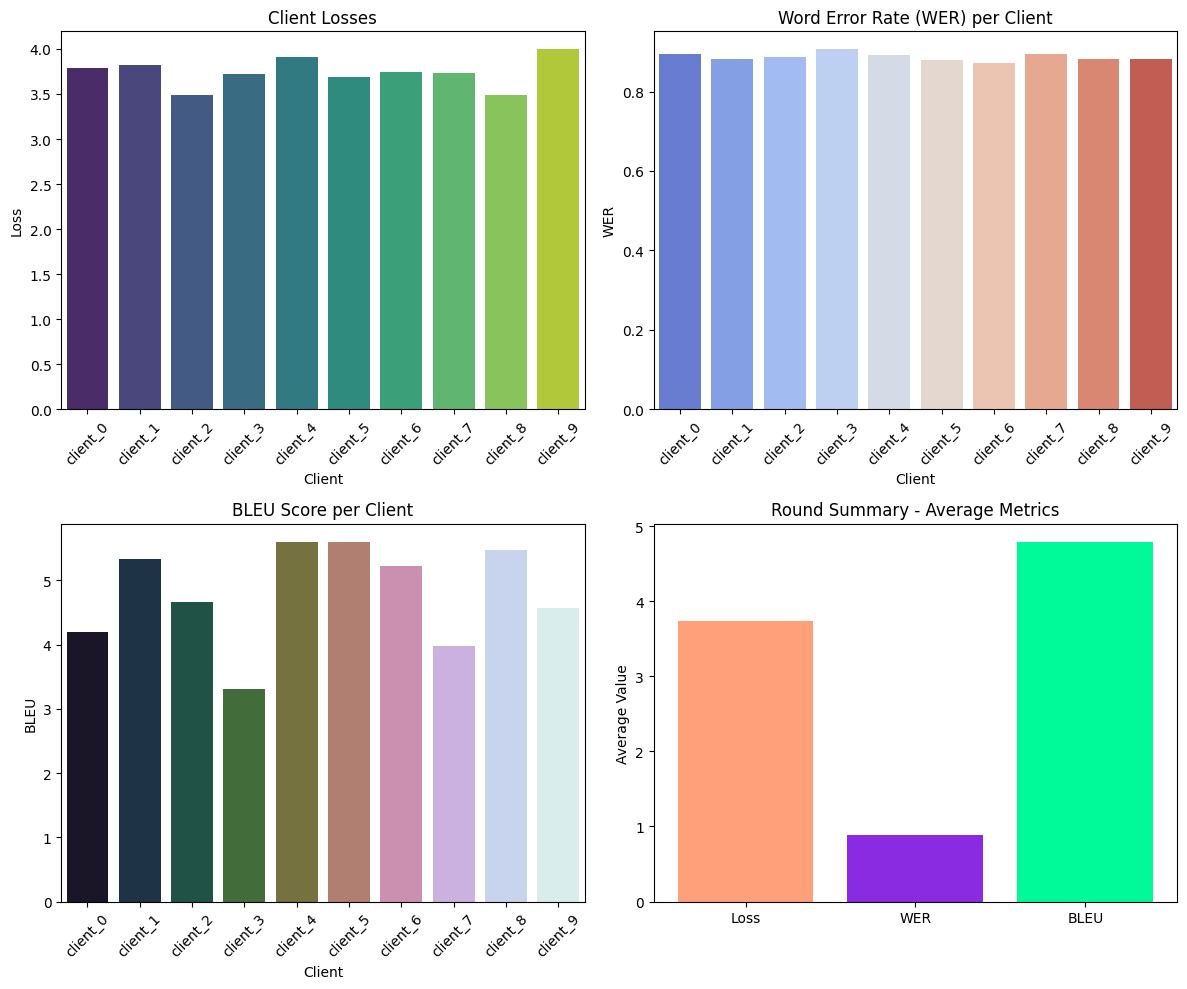

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Real data from your results
clients = ['client_0', 'client_1', 'client_2', 'client_3', 'client_4', 'client_5', 'client_6', 'client_7', 'client_8', 'client_9']

losses = [3.78726597627004, 3.8226261820111955, 3.4926821063546574, 3.717191477616628, 3.90975813070933,
          3.689499114689074, 3.7432971502605237, 3.7293643951416016, 3.4845151034268467, 3.996323585510254]

# WER (Word Error Rate) per client
wers = [0.8948213568847853, 0.883177570093458, 0.8876404494382022, 0.9064398541919806, 0.8928816662851912,
        0.8801830140120103, 0.8725778038755138, 0.8937931034482759, 0.8813916710595677, 0.8819969742813918]

# BLEU score per client
bleus = [4.1948003642113925, 5.324836603265572, 4.660331191870851, 3.3045080209642475, 5.591610674422566,
         5.599771545518178, 5.225220563371649, 3.9833787273413317, 5.465221433531758, 4.573357841888601]

# Round Summary Metrics
round_avg_loss = np.mean(losses)
round_avg_wer = np.mean(wers)
round_avg_bleu = np.mean(bleus)

# Create subplots for visualization
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# 1. Training Loss for each client
sns.barplot(x=clients, y=losses, ax=ax[0, 0], palette='viridis')
ax[0, 0].set_title('Client Losses')
ax[0, 0].set_xlabel('Client')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].tick_params(axis='x', rotation=45)

# 2. WER for each client
sns.barplot(x=clients, y=wers, ax=ax[0, 1], palette='coolwarm')
ax[0, 1].set_title('Word Error Rate (WER) per Client')
ax[0, 1].set_xlabel('Client')
ax[0, 1].set_ylabel('WER')
ax[0, 1].tick_params(axis='x', rotation=45)

# 3. BLEU score for each client
sns.barplot(x=clients, y=bleus, ax=ax[1, 0], palette='cubehelix')
ax[1, 0].set_title('BLEU Score per Client')
ax[1, 0].set_xlabel('Client')
ax[1, 0].set_ylabel('BLEU')
ax[1, 0].tick_params(axis='x', rotation=45)

# 4. Round Summary - average metrics
metrics = ['Loss', 'WER', 'BLEU']
values = [round_avg_loss, round_avg_wer, round_avg_bleu]
ax[1, 1].bar(metrics, values, color=['#FFA07A', '#8A2BE2', '#00FA9A'])
ax[1, 1].set_title('Round Summary - Average Metrics')
ax[1, 1].set_ylabel('Average Value')

plt.tight_layout()

plt.show()
